In [9]:

import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import tensorflow_datasets as tfds
import keras
from keras.models import Sequential
import keras.layers as layers


## Load dataset

In [10]:
(ds_train, ds_validation, ds_test), metadata  = tfds.load(
    "tf_flowers", 
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    as_supervised=True, 
    with_info=True
)

In [11]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/Users/haruiz/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [12]:
print(metadata.splits["train"].num_examples)
num_classes = metadata.features["label"].num_classes
labels = metadata.features["label"].names
print(num_classes)
print(labels)

3670
5
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


## Visualize a few images

2024-03-07 12:15:23.960435: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


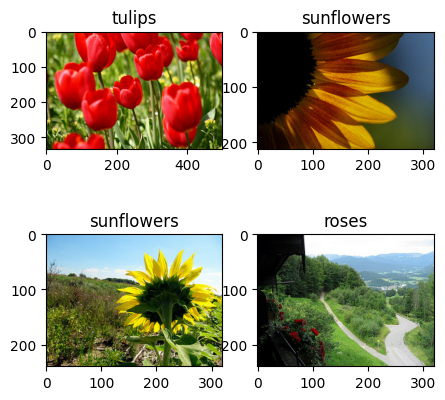

In [13]:

samples = ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    img_array, img_label_idx = img
    ax = fig.add_subplot(2,2, i + 1)    
    ax.imshow(img_array)    
    ax.set_title(labels[img_label_idx])
plt.show()

## Prepare dataset for training

In [14]:
IMG_SIZE = 180

resize_and_rescale = Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

def prepare_for_training(ds_subset, batch_size = 32, shuffle=False, augment=False):
    ds_subset  =  ds_subset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # shuffle the dataset if needed
    if shuffle:
        ds_subset = ds_subset.shuffle(1000)
    
    # create data batches
    ds_subset = ds_subset.batch(batch_size)

    # apply data augmentation
    if augment:        
        ds_subset= ds_subset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds_subset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


transformed_ds_train = prepare_for_training(ds_train, shuffle=True, augment=True)
transformed_ds_val = prepare_for_training(ds_validation)
transformed_ds_test = prepare_for_training(ds_test)

### Check how the images look like after processing

2024-03-07 12:15:25.130284: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


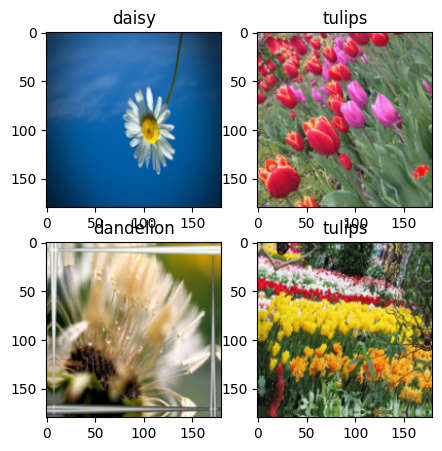

In [15]:
samples = transformed_ds_train.take(4)
fig = plt.figure(figsize=(5, 5))
for i,img in enumerate(tfds.as_numpy(samples)):
    batch_images, batch_labels = img
    #print(np.min(img_array), np.max(img_array))
    ax = fig.add_subplot(2,2, i + 1)    
    ax.imshow(batch_images[0])    
    ax.set_title(labels[batch_labels[0]])
plt.show()

### Create model

In [16]:
model = Sequential([    
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:

model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)       

### Train model and visualize training history

In [18]:
epochs=20
history = model.fit(transformed_ds_train,validation_data=transformed_ds_val, epochs=epochs)

Epoch 1/20
92/92 [==============================] - 6s 40ms/step - loss: 1.4588 - accuracy: 0.3781 - val_loss: 1.2371 - val_accuracy: 0.5368
Epoch 2/20
92/92 [==============================] - 2s 24ms/step - loss: 1.1788 - accuracy: 0.5181 - val_loss: 1.0498 - val_accuracy: 0.6049
Epoch 3/20
92/92 [==============================] - 2s 23ms/step - loss: 1.0376 - accuracy: 0.5981 - val_loss: 1.1297 - val_accuracy: 0.5668
Epoch 4/20
92/92 [==============================] - 2s 23ms/step - loss: 0.9949 - accuracy: 0.6148 - val_loss: 1.0732 - val_accuracy: 0.6104
Epoch 5/20
92/92 [==============================] - 2s 23ms/step - loss: 0.9869 - accuracy: 0.6206 - val_loss: 1.0505 - val_accuracy: 0.6022
Epoch 6/20
92/92 [==============================] - 2s 23ms/step - loss: 0.9262 - accuracy: 0.6451 - val_loss: 0.9531 - val_accuracy: 0.6621
Epoch 7/20
92/92 [==============================] - 2s 23ms/step - loss: 0.8953 - accuracy: 0.6628 - val_loss: 1.0776 - val_accuracy: 0.6458
Epoch 8/20
92

In [19]:
history_dict = history.history
val_acc_values = history_dict['val_accuracy']
train_acc_values = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
train_loss_values = history_dict['loss']
epochs_range = range(epochs)


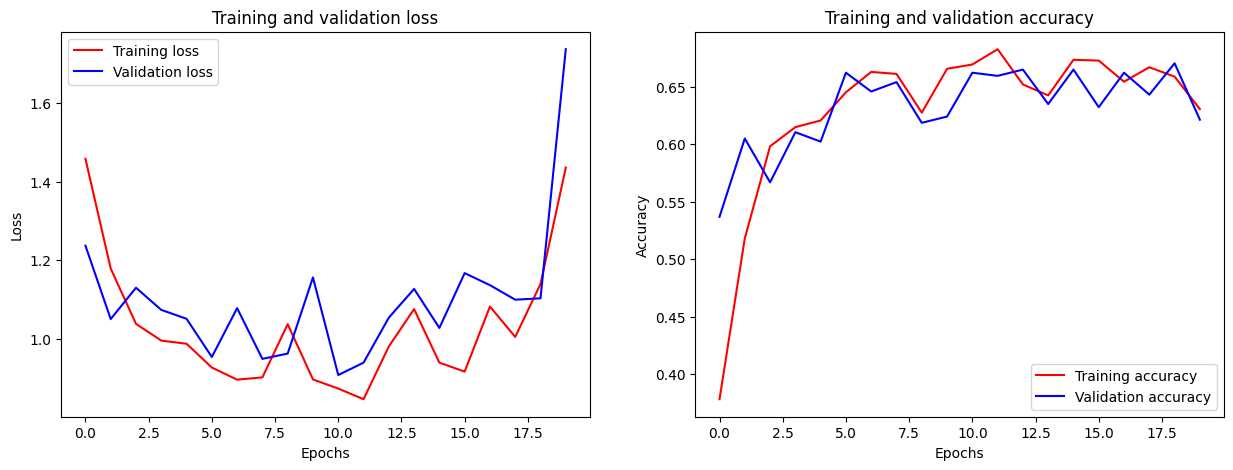

In [20]:
## Plotting the training and validation loss

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_values, 'r', label='Training loss')
plt.plot(epochs_range, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Plotting the training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_values, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Generic Metrics

12/12 [==============================] - 0s 9ms/step


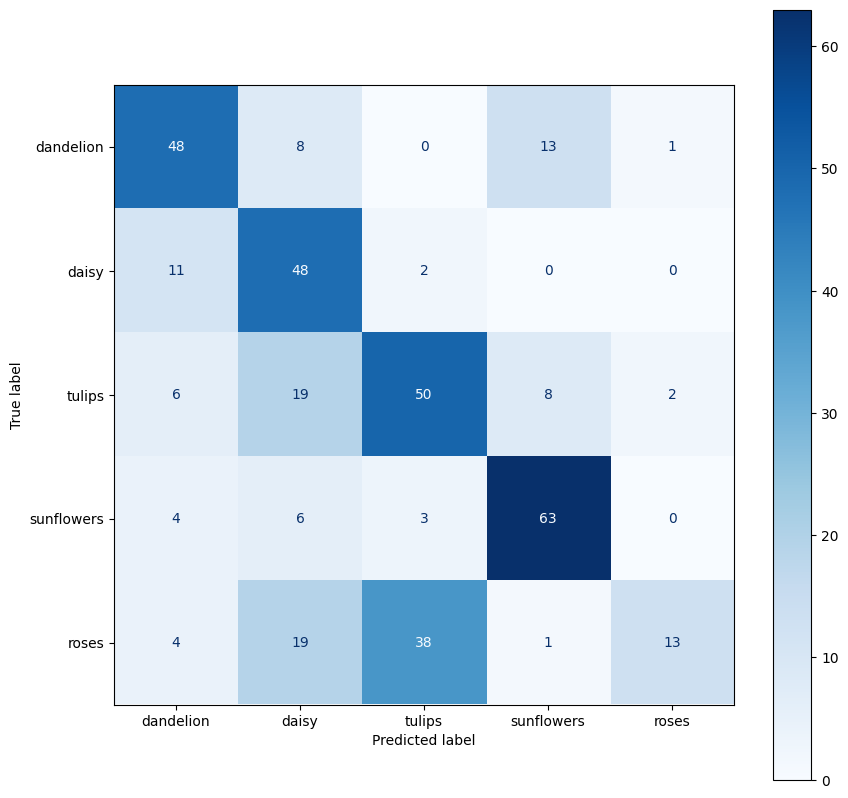

In [21]:
## create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y = [labels for imgs, labels in tfds.as_numpy(transformed_ds_test.unbatch())]
y_pred_probs = model.predict(transformed_ds_test)
y_pred = np.argmax(y_pred_probs, axis=1)


fig, _ = plt.subplots(nrows=1, figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.grid(False)
cf = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.show()

### Inspect model parameters

Inspect the model parameters and see how many parameters are there in the model.


In [22]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)       

### Inspect learned features

In [23]:

image_url = "https://static.wixstatic.com/media/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg/v1/fill/w_1000,h_666,al_c,q_90,usm_0.66_1.00_0.01/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg"
image_path = tf.keras.utils.get_file("image_test", image_url)
img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

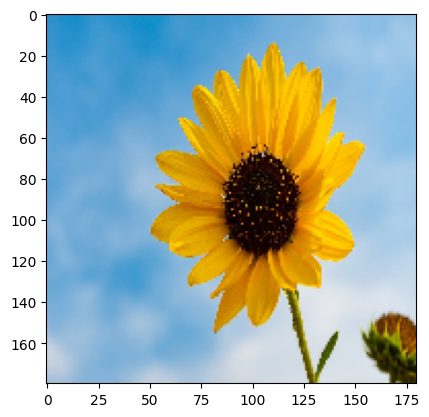

In [24]:
plt.imshow(img)

In [25]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = tf.convert_to_tensor(img_array)
img_tensor = tf.expand_dims(img_tensor, 0) 
img_tensor = tf.divide(img_tensor, 255.0)
scores = model(img_tensor)
probs = tf.nn.softmax(scores).numpy().squeeze()
class_idx = np.argmax(probs)
print(f"this image was classified as {labels[class_idx]} with a probability of {probs[class_idx]}")

this image was classified as dandelion with a probability of 0.4359949827194214


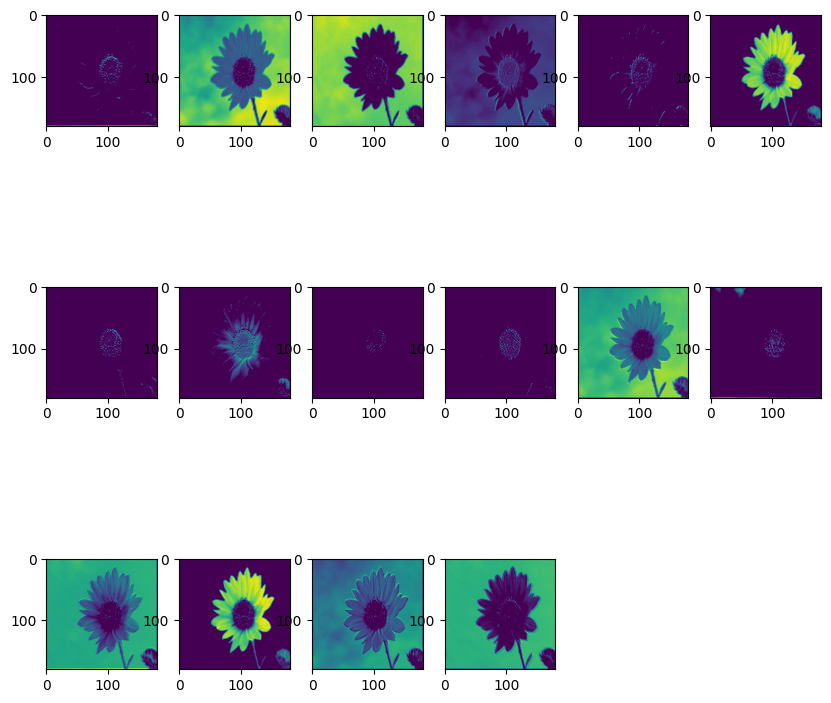

In [26]:
import math
cnn_layers = [layer for layer in model.layers  if isinstance(layer, layers.Conv2D)] 
selected_layers = cnn_layers[:1]       
features_extraction_model = Sequential(selected_layers)
features_map = features_extraction_model(img_tensor).numpy().squeeze()
num_fmaps = features_map.shape[-1]
num_rows = math.ceil(num_fmaps / 6)
fig = plt.figure(figsize=(10,10))
for i, fmap in enumerate(np.rollaxis(features_map, axis=2)):
    ax = fig.add_subplot(num_rows, 6, i + 1)
    ax.grid(False)
    ax.imshow(fmap, cmap='viridis')
plt.show()

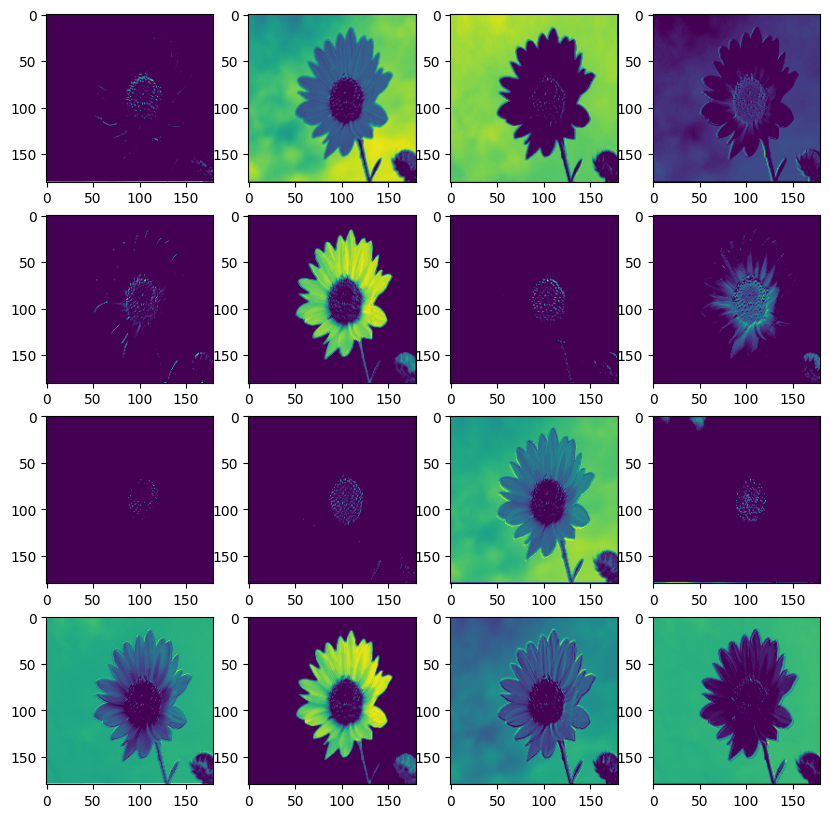

In [27]:
cnn_layer  = model.get_layer("conv2d_3")
features_map = cnn_layer(img_tensor)
features_map = features_map.numpy().squeeze()
fig = plt.figure(figsize=(10,10))
for i, fmap in enumerate(np.rollaxis(features_map, axis=2)):
    ax = fig.add_subplot(4,4, i + 1)
    ax.grid(False)
    ax.imshow(fmap, cmap='viridis')
plt.show()

### Save model

In [28]:
from pathlib import Path
MODELS_DIR = Path("models/flowers-model")
TF_MODEL_PATH = MODELS_DIR.joinpath("tf/model")

In [29]:
model.save(TF_MODEL_PATH)

INFO:tensorflow:Assets written to: models/flowers-model/tf/model/assets


INFO:tensorflow:Assets written to: models/flowers-model/tf/model/assets
